In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# imports pytorch
import torch


XLA_USE_BF16=1

In [2]:
import time
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image as Img
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
torch.backends.cudnn.enabled = False
#CUDA_LAUNCH_BLOCKING=1.

# Nueva sección

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
drive = r"../"
archivo_train = drive+r"train.csv"
archivo_test = drive+r"test.csv"
dir_imagenes = drive+r"all_imgs"

In [5]:
dataset = pd.read_csv(archivo_train, index_col=0)

In [6]:
dataset.describe

<bound method NDFrame.describe of                                                     path_img  label
idx_train                                                          
0          all_imgs/bc7696f4-1460-4d0b-a63d-f84b3be4da0f....      0
1          all_imgs/f8d50663-60d8-4da5-a8b8-79f954aec503....      2
2          all_imgs/51df0f29-758b-4741-ab74-a0ff8e21c044....      4
3          all_imgs/f61b81d3-3b79-4162-b4d6-4f1b39518c4c....      0
4          all_imgs/b21e0668-bd09-4794-9e90-da8ecffc4c1c....      0
...                                                      ...    ...
11195      all_imgs/b834c3fa-4fb0-4e38-ae32-7fd4a4141fe6....      2
11196      all_imgs/b93165ab-a87d-4ee1-8360-9b9728a3fc4b....      6
11197      all_imgs/a130fcbb-2b90-4922-b1e2-4770fddf6b91....      5
11198      all_imgs/bf402d68-ca0b-47f2-86f9-6e81d4bdbb38....      7
11199      all_imgs/a609a4a1-bd42-4053-9de7-5e94a812425b....      0

[11200 rows x 2 columns]>

In [7]:
dataset[:1]

,path_img,label
idx_train,,
0,all_imgs/bc7696f4-1460-4d0b-a63d-f84b3be4da0f....,0


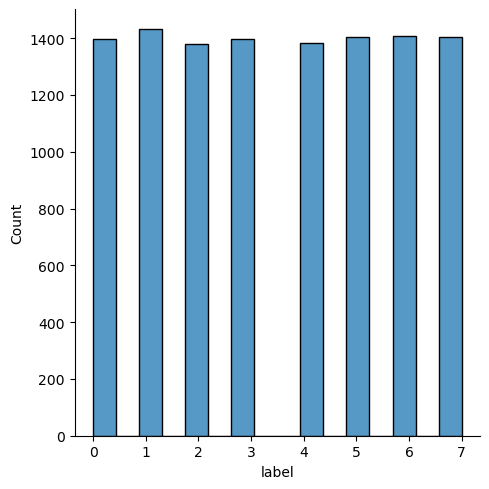

In [8]:
sns.displot(dataset.label)

In [9]:
torch.manual_seed(17)

In [10]:
class ComidasDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=0)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Img.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [11]:
transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])

In [12]:
dat_train = ComidasDataset(archivo_train, drive, transform=transform )
dat_test = ComidasDataset(archivo_test, drive, transform=transform )

In [13]:
""" Muy importante:
    Aqui se decide el batch size, que despues se incluye en la capa lineal
"""
train_dataloader = DataLoader(dat_train, batch_size=4, shuffle=False)
test_dataloader = DataLoader(dat_test, batch_size=4, shuffle=False)

Feature batch shape: torch.Size([4, 3, 256, 256])
Labels batch shape: torch.Size([4])


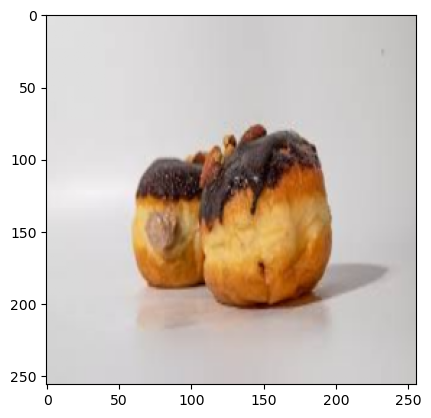

Label: 2


In [14]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# Habia que cambiar el orden, esta mal en el tuto
img = train_features[1].squeeze().permute(1, 2, 0)
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [15]:
# base de rnn sacada de https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model


# Define a convolution neural network
# Variotanal autoencoder ?
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # se han usadp kernels de 3x3 para no complicar los calculos de dimensiones
        
        # in_channes = 3 colores (RGB)
        # out_channes = salidad de la convolucion (3*4)? 
        # kernes_size = tamaño de la cuadricula de convolucion
        # stride = pasos que se mueve la convolucion
        # padding = bode generado para no perder features en los extremos
        # Sacal un featuremap de 12 canales: [batchx12x128x128}
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        # max pool reduce las dimensiones del featuremp
        # salida = [batchx12x64x64]
        self.pool = nn.MaxPool2d(2, 2)

        # salida = [batchx24x64x64]
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        
        # salida = [batchx24x64x64]
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)

        #test, no se usa en el resultado
        self.flat = nn.Flatten()

        self.fc2 = nn.Linear(24*128*128, 512)
        self.fc1 = nn.Linear(512, 8)
        
        
        
    def forward(self, input):
        # fase 1 se pasa el output de la convolucion a BatchNorm y a ReLu
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = F.relu(self.bn4(self.conv4(output)))
        output = F.relu(self.bn5(self.conv5(output)))
        output = output.view(-1, 24*128*128)
        output = self.fc2(output)
        output = self.fc1(output)
        return output


# Instantiate a neural network model 
model = Network()

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [17]:
# Funciones base sacadas de https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_loop(dataloader, model, loss_fn, optimizer):
    best_accuracy = 0.0
    
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = xm.xla_device()
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model = model.to(device)
    size = len(dataloader.dataset)

    for batch, (images, label) in enumerate(dataloader):
        # get the inputs
        #X = Variable(torch.tensor(images))
        images = images.to(device)
        y = Variable(label.to(device))

        # Compute prediction and loss
        pred = model(images)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(batch)
        # print cada 2 batches = 2 * 1024 = 2048 imagenes
        if batch % 2 == 0:
            loss, current = loss.item(), (batch + 1) * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = xm.xla_device()

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
from torch.optim import Adam

learning_rate = 0.01 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    torch.save(model.state_dict(), drive+f"model_{time.monotonic_ns()}.pth") 
print("Done!")

Epoch 1
-------------------------------
The model will be running on cuda:0 device


RuntimeError: CUDA error: unknown error

In [ ]:
torch.save(model.state_dict(), drive+"modelo_final.pth") 

In [ ]:


time_ns = time.monotonic_ns()
time_ns